In [1]:
import numpy as np
import pandas as pd
import itertools
import pathlib

import os
os.chdir('../')

import warnings
warnings.simplefilter('ignore')

from fp.traindata_samplers import CompleteData
from fp.missingvalue_handlers import CompleteCaseAnalysis
from fp.dataset_experiments import GermanCreditDatasetSexExperiment
from fp.scalers import NamedStandardScaler
from fp.learners import LogisticRegression, DecisionTree
from fp.post_processors import NoPostProcessing, RejectOptionPostProcessing
from fp.pre_processors import NoPreProcessing, DIRemover


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# creating list of parameters that we will alter to observe variations
seeds = [0xbeef, 0xcafe, 0xdead]
learners = [LogisticRegression()]

processors = [(NoPreProcessing(), NoPostProcessing()), (DIRemover(1.0), NoPostProcessing()), (NoPreProcessing(), RejectOptionPostProcessing())]


skyline_order = ['accuracy', 'selection_rate', 'false_discovery_rate']
skyline_formula = {'accuracy': 0.5, 'selection_rate': 0.3, 'false_discovery_rate': 0.2}

In [3]:
def calculate_metrics(seed, learners, pre_processors, post_processors, skyline_strategy):
    '''
    Experiment function to run the experiments with multiple combinations of learners and processors in the input
    '''
    exp = GermanCreditDatasetSexExperiment(
        fixed_random_seed=seed,
        train_data_sampler=CompleteData(),
        missing_value_handler=CompleteCaseAnalysis(),
        numeric_attribute_scaler=NamedStandardScaler(),
        learners=learners,
        pre_processors=pre_processors,
        post_processors=post_processors,
        optimal_validation_strategy=skyline_strategy)
    exp.run()
    return exp.generate_file_path()

def run_exp(seeds, learners, processors, skyline_strategy):
    '''
    This is the main driver function that calls the calculate_metrics to give metrices on combinations of various learners, pre and post processing techniques.
    '''
    skyline_res_folder = {}
    for seed in seeds:
        skyline_res_folder[seed] = calculate_metrics(seed, learners, [x[0] for x in processors], [x[1] for x in processors], skyline_strategy)
    return skyline_res_folder

In [4]:
skyline_order_results = run_exp(seeds, learners, processors, skyline_order)
print (skyline_order_results)

{48879: 'logs/2020-07-06_22-44-06-039_germancreditsex/', 51966: 'logs/2020-07-06_22-44-16-697_germancreditsex/', 57005: 'logs/2020-07-06_22-44-26-018_germancreditsex/'}


In [5]:
skyline_formula_results = run_exp(seeds, learners, processors, skyline_formula)
print (skyline_formula_results)

{48879: 'logs/2020-07-06_22-44-33-636_germancreditsex/', 51966: 'logs/2020-07-06_22-44-42-588_germancreditsex/', 57005: 'logs/2020-07-06_22-44-52-624_germancreditsex/'}


## Visualize the result of skyline selection for a single trial

In [18]:
# read the skyline options for current seed
focus_seed = 0xdead
skyline_order_df = pd.read_csv(skyline_order_results[focus_seed]+"skyline_options.csv")
skyline_order_df.head(5)

,setting,data,accuracy,selection_rate,false_discovery_rate,skyline,optimal
0,germancreditsex__no_pre_processing__complete_c...,val,0.710000,0.890000,-0.280899,79.619101,1
1,germancreditsex__no_pre_processing__complete_c...,test,0.771144,0.800995,-0.173913,84.950465,1
2,germancreditsex__no_pre_processing__complete_c...,val,0.710000,0.890000,-0.280899,79.619101,1
3,germancreditsex__no_pre_processing__complete_c...,test,0.756219,0.925373,-0.225806,84.649815,1
4,germancreditsex__diremover-1.0__complete_case_...,val,0.700000,0.880000,-0.284091,78.515909,0


In [19]:
skyline_formula_df = pd.read_csv(skyline_formula_results[focus_seed]+"skyline_options.csv")
skyline_formula_df.head(5)

,setting,data,accuracy,selection_rate,false_discovery_rate,skyline,optimal
0,germancreditsex__no_pre_processing__complete_c...,val,0.710000,0.890000,-0.280899,0.565820,1
1,germancreditsex__no_pre_processing__complete_c...,test,0.771144,0.800995,-0.173913,0.591088,1
2,germancreditsex__no_pre_processing__complete_c...,val,0.710000,0.890000,-0.280899,0.565820,1
3,germancreditsex__no_pre_processing__complete_c...,test,0.756219,0.925373,-0.225806,0.610560,1
4,germancreditsex__diremover-1.0__complete_case_...,val,0.700000,0.880000,-0.284091,0.557182,0


In [20]:
# rename settings to draw the plots of metrics in the skyline input
setting_labels = {'reject_option': 'RO', 'diremover-1.0': 'DI1.0', 
                  'no_pre_processing': 'NoPre', 'no_post_processing': 'NoPost',
                  'DecisionTree': 'DT', 'LogisticRegression': 'LR'}
skyline_order_df['setting'] = skyline_order_df['setting'].apply(lambda x: '_'.join([setting_labels[x.split('__')[i].replace('-'+str(focus_seed), '')] for i in range(len(x.split('__'))) if i in [1, 5, 6]]))
skyline_formula_df['setting'] = skyline_formula_df['setting'].apply(lambda x: '_'.join([setting_labels[x.split('__')[i].replace('-'+str(focus_seed), '')] for i in range(len(x.split('__'))) if i in [1, 5, 6]]))
skyline_order_df = skyline_order_df[skyline_order_df['setting'].apply(lambda x: 'NoP' in x)]
skyline_formula_df = skyline_formula_df[skyline_formula_df['setting'].apply(lambda x: 'NoP' in x)]

In [21]:
def output_scatter_plot(f_name, df, x_col, y_col, hue_col='setting', color_p='Set2'):
    sns.set(style='whitegrid', font_scale=1.5)
    # add jitters for x to account for ties in the values
    data = df.copy()
    noise_para = 100
    data[x_col] += np.random.random(data.shape[0])/noise_para - 1/noise_para/2
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(13, 6))
    sns.scatterplot(x_col, y_col, hue_col, data=data.query("data == 'val'"), ax=ax1, style='optimal', s=100)
    sns.scatterplot(x_col, y_col, hue_col, data=data.query("data == 'test'"), ax=ax2, style='optimal', s=100)
    ax1.set_title('validation')    
    ax2.set_title('test')    
    plt.tight_layout()
    
    # save plot into the disc
    cur_f_path = f_name[0:f_name.rfind("/") + 1]
    if not os.path.exists(cur_f_path):
        directory = os.path.dirname(cur_f_path)
        pathlib.Path(directory).mkdir(parents=True, exist_ok=True)
    plt.savefig(f_name + '.png')

In [24]:
skyline_order_df

,setting,data,accuracy,selection_rate,false_discovery_rate,skyline,optimal
0,NoPre_LR_RO,val,0.710000,0.890000,-0.280899,79.619101,1
1,NoPre_LR_RO,test,0.771144,0.800995,-0.173913,84.950465,1
2,NoPre_LR_NoPost,val,0.710000,0.890000,-0.280899,79.619101,1
3,NoPre_LR_NoPost,test,0.756219,0.925373,-0.225806,84.649815,1
6,DI1.0_LR_NoPost,val,0.700000,0.880000,-0.284091,78.515909,0
7,DI1.0_LR_NoPost,test,0.781095,0.890547,-0.201117,86.813808,0


In [25]:
skyline_formula_df

,setting,data,accuracy,selection_rate,false_discovery_rate,skyline,optimal
0,NoPre_LR_RO,val,0.710000,0.890000,-0.280899,0.565820,1
1,NoPre_LR_RO,test,0.771144,0.800995,-0.173913,0.591088,1
2,NoPre_LR_NoPost,val,0.710000,0.890000,-0.280899,0.565820,1
3,NoPre_LR_NoPost,test,0.756219,0.925373,-0.225806,0.610560,1
6,DI1.0_LR_NoPost,val,0.700000,0.880000,-0.284091,0.557182,0
7,DI1.0_LR_NoPost,test,0.781095,0.890547,-0.201117,0.617488,0


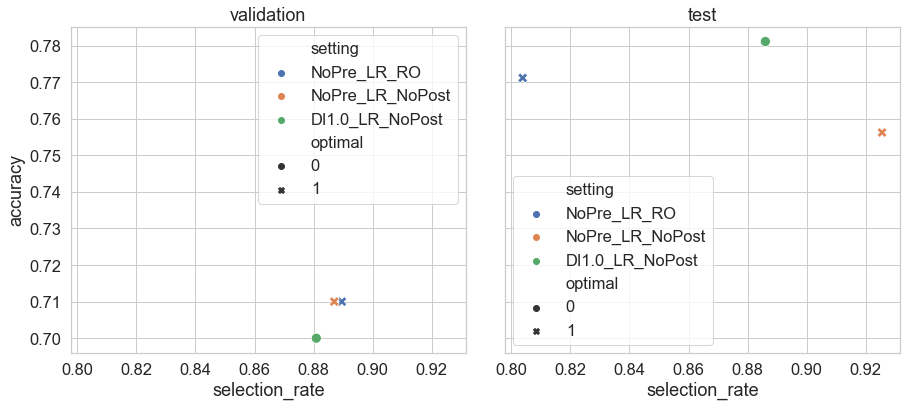

In [22]:
x_col = 'selection_rate'
y_col = 'accuracy'
output_fname = "_".join(['examples/skyline_plots/Order', 's'+str(focus_seed), x_col, y_col])

output_scatter_plot(output_fname, skyline_order_df, x_col, y_col)

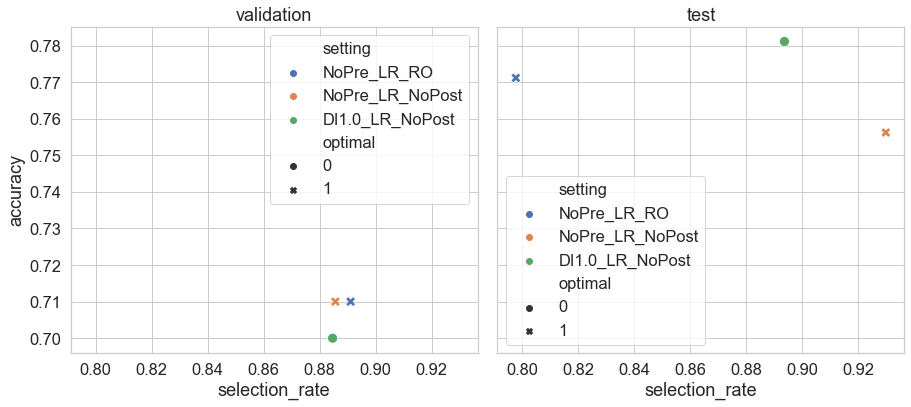

In [23]:
x_col = 'selection_rate'
y_col = 'accuracy'
output_fname = "_".join(['examples/skyline_plots/Formula', 's'+str(focus_seed), x_col, y_col])

output_scatter_plot(output_fname, skyline_formula_df, x_col, y_col)